#Description
**Data Science Work Product: Predicting Volume of Water Draws** <br>
**DS1.4**<br>
Purpose<br>
Prediction of volume of water drawn from the geyser <br>
<br>
by<br>
Fonyuy Boris Lami


In [1662]:
# installing packages
!pip install catboost

In [1663]:
# import libraries
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb
import numpy as np
import math
from sklearn.model_selection import GridSearchCV


In [1664]:
st = "*****************"

In [1665]:
# load train data set and view first five rows
train = pd.read_csv('geyser_dataset.csv')
print(st + 'shape of train' + st, train.shape, sep='\n')
train.head(5)

*****************shape of train*****************
(34842, 8)


,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
0,2020-10-03 00:03:25+02:00,52.66,15.66,47.93,16.02,0.0,0.0,False
1,2020-10-03 00:08:21+02:00,52.55,15.64,48.24,15.94,0.0,0.0,False
2,2020-10-03 00:13:23+02:00,52.37,15.53,47.93,15.92,0.0,0.0,False
3,2020-10-03 00:18:25+02:00,52.37,15.51,47.89,15.92,0.0,0.0,False
4,2020-10-03 00:23:21+02:00,52.37,15.46,47.82,15.84,0.0,0.0,False


In [1666]:
# load test data set and view first five rows
test = pd.read_csv('geyser_test_set.csv')
print(st + 'shape of test' + st, test.shape, sep='\n')
test.head(5)

*****************shape of test*****************
(2895, 8)


,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
0,2021-02-01 00:03:24+02:00,37.91,22.73,42.59,22.07,0.0,0.0,False
1,2021-02-01 00:08:25+02:00,37.97,22.57,45.30,21.74,0.0,0.0,False
2,2021-02-01 00:13:22+02:00,38.08,22.57,43.51,21.46,0.0,0.0,False
3,2021-02-01 00:18:24+02:00,38.02,22.47,42.68,21.28,0.0,0.0,False
4,2021-02-01 00:23:25+02:00,38.11,22.23,46.76,21.15,0.0,0.0,False


In [1667]:
# drop Water flow column since this is the target variable
test.drop('Volume of water drawn', axis=1, inplace=True)
test.head(5)

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow
0,2021-02-01 00:03:24+02:00,37.91,22.73,42.59,22.07,0.0,False
1,2021-02-01 00:08:25+02:00,37.97,22.57,45.30,21.74,0.0,False
2,2021-02-01 00:13:22+02:00,38.08,22.57,43.51,21.46,0.0,False
3,2021-02-01 00:18:24+02:00,38.02,22.47,42.68,21.28,0.0,False
4,2021-02-01 00:23:25+02:00,38.11,22.23,46.76,21.15,0.0,False


EDA

In [1668]:
# view feature names
print(st + 'train cols' + st + '\n', train.columns)
print(st + 'test cols' + st + '\n', test.columns)

*****************train cols*****************
 Index(['time_index', 'Internal temperature', 'Inlet temperature',
       'Outlet temperature', 'Ambient temperature', 'Energy consumed',
       'Volume of water drawn', 'Water flow'],
      dtype='object')
*****************test cols*****************
 Index(['time_index', 'Internal temperature', 'Inlet temperature',
       'Outlet temperature', 'Ambient temperature', 'Energy consumed',
       'Water flow'],
      dtype='object')


In [1669]:
# check for missing values
print(st + 'train' + st + '\n', train.isna().sum().sort_values())
print(st + 'test' + st + '\n', test.isna().sum().sort_values())  # hurray! :-), no missing values

*****************train*****************
 time_index               0
Internal temperature     0
Inlet temperature        0
Outlet temperature       0
Ambient temperature      0
Energy consumed          0
Volume of water drawn    0
Water flow               0
dtype: int64
*****************test*****************
 time_index              0
Internal temperature    0
Inlet temperature       0
Outlet temperature      0
Ambient temperature     0
Energy consumed         0
Water flow              0
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


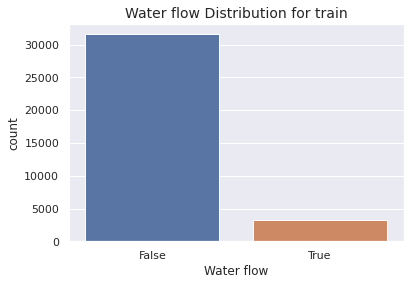

In [1670]:
# viewing nature of data set if it is balanced
sns.countplot(train['Water flow'])
plt.title('Water flow Distribution for train', fontdict={'size':14});

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


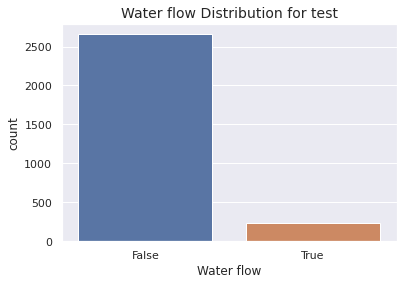

In [1671]:
# viewing nature of data set if it is balanced
sns.countplot(test['Water flow'])
plt.title('Water flow Distribution for test', fontdict={'size':14});

In [1672]:
# initial info for train and test
print(st + 'train' + st + '\n')
print(train.info())
print('\n' + st + 'test' + st + '\n')
print(test.info())

*****************train*****************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34842 entries, 0 to 34841
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time_index             34842 non-null  object 
 1   Internal temperature   34842 non-null  float64
 2   Inlet temperature      34842 non-null  float64
 3   Outlet temperature     34842 non-null  float64
 4   Ambient temperature    34842 non-null  float64
 5   Energy consumed        34842 non-null  float64
 6   Volume of water drawn  34842 non-null  float64
 7   Water flow             34842 non-null  bool   
dtypes: bool(1), float64(6), object(1)
memory usage: 1.9+ MB
None

*****************test*****************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2895 entries, 0 to 2894
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time_index 

In [1673]:
# time_index to datetime format for better manipulation
train['time_index'] = pd.to_datetime(train['time_index'])
test['time_index'] = pd.to_datetime(test['time_index'])

In [1674]:
# confirm whether the changes have been applied successfully
print(st + 'train' + st + '\n')
print(train.info())
print('\n' + st + 'test' + st + '\n')
print(test.info())

*****************train*****************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34842 entries, 0 to 34841
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype                                
---  ------                 --------------  -----                                
 0   time_index             34842 non-null  datetime64[ns, pytz.FixedOffset(120)]
 1   Internal temperature   34842 non-null  float64                              
 2   Inlet temperature      34842 non-null  float64                              
 3   Outlet temperature     34842 non-null  float64                              
 4   Ambient temperature    34842 non-null  float64                              
 5   Energy consumed        34842 non-null  float64                              
 6   Volume of water drawn  34842 non-null  float64                              
 7   Water flow             34842 non-null  bool                                 
dtypes: bool(1), datetime64[ns,

In [1675]:
# periodicity in readings (data readings every 5 minutes averagely)
period_train = (train['time_index'].shift(-1) - train['time_index']).mean()
period_test = (test['time_index'].shift(-1) - test['time_index']).mean()
period = (period_test + period_train) / 2.0
print(st + 'Period train ' + st, period_train, st + 'Period test ' + st, period_test, st + 'Average period ' + st, period, sep = '\n')
print('\n' + st + 'in seconds' + st)
print(st + 'Period train ' + st, period_train.total_seconds(), st + 'Period test ' + st, period_test.total_seconds(), st + 'Average period ' + st, period.total_seconds(), sep = '\n')

*****************Period train *****************
0 days 00:05:00.051577164
*****************Period test *****************
0 days 00:04:58.445404284
*****************Average period *****************
0 days 00:04:59.248490724

*****************in seconds*****************
*****************Period train *****************
300.051577
*****************Period test *****************
298.445404
*****************Average period *****************
299.24849


In [1676]:
# map False to 0 and True to 1 in Water flow
true_false_map = {False:0, True:1}
train['Water flow'] = train['Water flow'].replace(true_false_map)
test['Water flow'] = test['Water flow'].replace(true_false_map)

In [1677]:
# water drawn volume is a multiple of
basic_unit_water_drawn_volume = np.gcd.reduce(train.loc[train['Water flow'] == 1 , 'Volume of water drawn'].astype(int))
print(st + 'smallest unit of water drawn volume (L) ' + st, basic_unit_water_drawn_volume, sep='\n')

*****************smallest unit of water drawn volume (L) *****************
5


In [1678]:
# view head of train
train.head(5)

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
0,2020-10-03 00:03:25+02:00,52.66,15.66,47.93,16.02,0.0,0.0,0
1,2020-10-03 00:08:21+02:00,52.55,15.64,48.24,15.94,0.0,0.0,0
2,2020-10-03 00:13:23+02:00,52.37,15.53,47.93,15.92,0.0,0.0,0
3,2020-10-03 00:18:25+02:00,52.37,15.51,47.89,15.92,0.0,0.0,0
4,2020-10-03 00:23:21+02:00,52.37,15.46,47.82,15.84,0.0,0.0,0


In [1679]:
# view head of test
test.head(5)

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow
0,2021-02-01 00:03:24+02:00,37.91,22.73,42.59,22.07,0.0,0
1,2021-02-01 00:08:25+02:00,37.97,22.57,45.30,21.74,0.0,0
2,2021-02-01 00:13:22+02:00,38.08,22.57,43.51,21.46,0.0,0
3,2021-02-01 00:18:24+02:00,38.02,22.47,42.68,21.28,0.0,0
4,2021-02-01 00:23:25+02:00,38.11,22.23,46.76,21.15,0.0,0


In [1680]:
# confirm whether the changes have been applied successfully
print(st + 'train' + st + '\n')
print(train.info())
print('\n' + st + 'test' + st + '\n')
print(test.info())

*****************train*****************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34842 entries, 0 to 34841
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype                                
---  ------                 --------------  -----                                
 0   time_index             34842 non-null  datetime64[ns, pytz.FixedOffset(120)]
 1   Internal temperature   34842 non-null  float64                              
 2   Inlet temperature      34842 non-null  float64                              
 3   Outlet temperature     34842 non-null  float64                              
 4   Ambient temperature    34842 non-null  float64                              
 5   Energy consumed        34842 non-null  float64                              
 6   Volume of water drawn  34842 non-null  float64                              
 7   Water flow             34842 non-null  int64                                
dtypes: datetime64[ns, pytz.Fix

In [1681]:
# description of train
print('train description')
train.describe()

train description


,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow
count,34842.000000,34842.000000,34842.000000,34842.000000,34842.000000,34842.000000,34842.000000
mean,48.955056,25.837808,47.193000,25.599737,24.629920,5.048792,0.093881
std,9.723460,5.993500,6.378019,6.296403,76.299521,27.159952,0.291667
min,16.840000,10.500000,25.780000,10.570000,0.000000,0.000000,0.000000
25%,43.480000,21.330000,42.310000,20.740000,0.000000,0.000000,0.000000
50%,50.850000,25.210000,47.620000,24.650000,0.000000,0.000000,0.000000
75%,56.440000,29.910000,52.250000,30.270000,0.000000,0.000000,0.000000
max,63.330000,45.660000,63.190000,45.230000,372.000000,435.000000,1.000000


In [1682]:
# description of test
print('test description')
test.describe()

test description


,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow
count,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000,2895.000000
mean,49.418124,28.991589,47.376062,28.623516,23.031869,0.081865
std,9.731533,4.195419,5.801321,4.678068,74.383632,0.274207
min,26.390000,20.840000,34.880000,19.560000,0.000000,0.000000
25%,40.980000,26.260000,42.385000,24.840000,0.000000,0.000000
50%,52.660000,28.590000,47.580000,28.370000,0.000000,0.000000
75%,57.290000,31.400000,52.140000,32.190000,0.000000,0.000000
max,62.900000,41.400000,61.180000,40.210000,287.950000,1.000000


In [1683]:
# evaluation of temperature difference inlet_outlet and internal_ambient
train['inlet_outlet_temp_diff'] = train['Outlet temperature'] - train['Inlet temperature']
train['internal_external_temp_diff'] = train['Internal temperature'] - train['Ambient temperature']

test['inlet_outlet_temp_diff'] = test['Outlet temperature'] - test['Inlet temperature']
test['internal_external_temp_diff'] = test['Internal temperature'] - test['Ambient temperature']

In [1684]:
train.head()

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow,inlet_outlet_temp_diff,internal_external_temp_diff
0,2020-10-03 00:03:25+02:00,52.66,15.66,47.93,16.02,0.0,0.0,0,32.27,36.64
1,2020-10-03 00:08:21+02:00,52.55,15.64,48.24,15.94,0.0,0.0,0,32.60,36.61
2,2020-10-03 00:13:23+02:00,52.37,15.53,47.93,15.92,0.0,0.0,0,32.40,36.45
3,2020-10-03 00:18:25+02:00,52.37,15.51,47.89,15.92,0.0,0.0,0,32.38,36.45
4,2020-10-03 00:23:21+02:00,52.37,15.46,47.82,15.84,0.0,0.0,0,32.36,36.53


In [1685]:
test.head()

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow,inlet_outlet_temp_diff,internal_external_temp_diff
0,2021-02-01 00:03:24+02:00,37.91,22.73,42.59,22.07,0.0,0,19.86,15.84
1,2021-02-01 00:08:25+02:00,37.97,22.57,45.30,21.74,0.0,0,22.73,16.23
2,2021-02-01 00:13:22+02:00,38.08,22.57,43.51,21.46,0.0,0,20.94,16.62
3,2021-02-01 00:18:24+02:00,38.02,22.47,42.68,21.28,0.0,0,20.21,16.74
4,2021-02-01 00:23:25+02:00,38.11,22.23,46.76,21.15,0.0,0,24.53,16.96


In [1686]:
# generating water flow events
event_train_list = []
count_number = 0
for index, group in train.groupby([(train['Water flow'] != train['Water flow'].shift()).cumsum()]):
  if max(group['Water flow'].tolist()) == 1:
    duration_of_flow = group.iloc[-1, 0] - group.iloc[0, 0]
    record = [group.iloc[0, 0], group['Internal temperature'].mean(), group['Inlet temperature'].mean(), group['Outlet temperature'].mean(),  
              group['Ambient temperature'].mean(),   group['Energy consumed'].mean(), group['Volume of water drawn'].mean(), group['Water flow'].sum(),
              group['inlet_outlet_temp_diff'].mean(),	 group['internal_external_temp_diff'].mean(), period.total_seconds() + duration_of_flow.total_seconds(), 
              group['inlet_outlet_temp_diff'].mean()/(group['Water flow'].sum() * (period.total_seconds() / 60)), 
              group['internal_external_temp_diff'].mean()/(group['Water flow'].sum() * (period.total_seconds() / 60))]
    event_train_list.append(record)
  count_number += 1

cols = list(train.columns)
cols.append('duration_of_flow')
cols.append('inlet_outlet_pressure')
cols.append('internal_external_pressure')
event_train = pd.DataFrame(data=event_train_list, columns=cols)
event_train['Volume of water drawn'] = round(event_train['Volume of water drawn'])
event_train.head(5)


,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Volume of water drawn,Water flow,inlet_outlet_temp_diff,internal_external_temp_diff,duration_of_flow,inlet_outlet_pressure,internal_external_pressure
0,2020-10-03 08:03:24+02:00,47.342500,16.305,47.48,17.057500,132.075,32.0,4,31.175,30.285000,1198.24849,1.562665,1.518053
1,2020-10-03 09:38:24+02:00,60.130000,20.430,51.59,21.350000,0.000,5.0,1,31.160,38.780000,299.24849,6.247651,7.775478
2,2020-10-03 10:18:22+02:00,31.955714,18.520,54.01,21.311429,0.000,165.0,7,35.490,10.644286,2099.24849,1.016546,0.304886
3,2020-10-03 10:58:25+02:00,16.920000,20.230,46.73,21.480000,0.000,5.0,1,26.500,-4.560000,299.24849,5.313310,-0.914290
4,2020-10-03 11:13:25+02:00,17.020000,22.310,45.54,22.720000,0.000,5.0,2,23.230,-5.700000,595.24849,2.328834,-0.571431


In [1687]:
# generating water flow events
event_test_list = []
count_number = 0
for index, group in test.groupby([(test['Water flow'] != test['Water flow'].shift()).cumsum()]):
  if max(group['Water flow'].tolist()) == 1:
    duration_of_flow = group.iloc[-1, 0] - group.iloc[0, 0]
    record = [group.iloc[0, 0], group['Internal temperature'].mean(), group['Inlet temperature'].mean(), group['Outlet temperature'].mean(),  
              group['Ambient temperature'].mean(),   group['Energy consumed'].mean(), group['Water flow'].sum(),
              group['inlet_outlet_temp_diff'].mean(),	 group['internal_external_temp_diff'].mean(), period.total_seconds() + duration_of_flow.total_seconds(), 
              group['inlet_outlet_temp_diff'].mean()/(group['Water flow'].sum() * (period.total_seconds() / 60)), 
              group['internal_external_temp_diff'].mean()/(group['Water flow'].sum() * (period.total_seconds() / 60))]
    event_test_list.append(record)
  count_number += 1

cols = list(test.columns)
cols.append('duration_of_flow')
cols.append('inlet_outlet_pressure')
cols.append('internal_external_pressure')
event_test = pd.DataFrame(data=event_test_list, columns=cols)
event_test.head(5)

,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow,inlet_outlet_temp_diff,internal_external_temp_diff,duration_of_flow,inlet_outlet_pressure,internal_external_pressure
0,2021-02-01 07:58:21+02:00,45.630,27.650,35.480,24.050,276.190,1,7.830,21.580,299.24849,1.569933,4.326839
1,2021-02-01 08:28:21+02:00,53.140,25.455,53.455,24.600,267.380,2,28.000,28.540,600.24849,2.807032,2.861167
2,2021-02-01 08:58:21+02:00,60.346,24.160,58.198,23.734,116.642,5,34.038,36.612,1500.24849,1.364939,1.468158
3,2021-02-01 10:03:22+02:00,56.935,25.365,58.070,25.075,0.000,2,32.705,31.860,601.24849,3.278713,3.194001
4,2021-02-01 10:38:24+02:00,53.690,25.730,57.580,26.730,0.000,1,31.850,26.960,299.24849,6.385997,5.405541


In [1689]:
# adding 2 hours GMT + 2
hours = 2
event_train["time_index"] = event_train["time_index"] + dt.timedelta(hours = hours)
event_test["time_index"] = event_test["time_index"] + dt.timedelta(hours = hours)

In [1690]:

# Monday is 1, Sunday is 7
for date_feature in ['year', 'month', 'day', 'hour', 'minute']:
  if date_feature == 'day':
    event_train['time_index' + '_' + date_feature + '_number'] = event_train['time_index'].dt.dayofweek + 1
    event_train['time_index' + '_' + date_feature] = getattr(event_train['time_index'].dt, date_feature) 
    event_test['time_index' + '_' + date_feature + '_number'] = event_test['time_index'].dt.dayofweek + 1
    event_test['time_index' + '_' + date_feature] = getattr(event_test['time_index'].dt, date_feature)
  else:
    event_train['time_index' + '_' + date_feature] = getattr(event_train['time_index'].dt, date_feature) 
    event_test['time_index' + '_' + date_feature] = getattr(event_test['time_index'].dt, date_feature)
    

event_train["time_index"] = event_train["time_index"].dt.strftime('%d/%m/%y %H:%M:%S')
event_test["time_index"] = event_test["time_index"].dt.strftime('%d/%m/%y %H:%M:%S')

In [1691]:
#map 0-5: 0, 6-11: 1, 12-17:2, 18:23:3
day_quarter_map = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0,
                   6:1, 7:1, 8:1, 9:1, 10:1, 11:1,
                   12:2, 13:2, 14:2, 15:2, 16:2, 17:2,
                   18:3, 19:3, 20:3, 21:3, 22:3, 23:3,
                   }
event_train['time_index_quarter'] = event_train['time_index_hour']
event_test['time_index_quarter'] = event_test['time_index_hour']

event_train['time_index_quarter'] = event_train['time_index_quarter'].replace(day_quarter_map)
event_test['time_index_quarter'] = event_test['time_index_quarter'].replace(day_quarter_map)

In [1692]:
# move target variable to last column
cols = list(event_train.columns)
event_train = event_train[cols[0:6] + cols[7:] + [cols[6]]]
print('event train data shape', event_train.shape, sep='\n')
event_train.head(5)

event train data shape
(1844, 20)


,time_index,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow,inlet_outlet_temp_diff,internal_external_temp_diff,duration_of_flow,inlet_outlet_pressure,internal_external_pressure,time_index_year,time_index_month,time_index_day_number,time_index_day,time_index_hour,time_index_minute,time_index_quarter,Volume of water drawn
0,03/10/20 10:03:24,47.342500,16.305,47.48,17.057500,132.075,4,31.175,30.285000,1198.24849,1.562665,1.518053,2020,10,6,3,10,3,1,32.0
1,03/10/20 11:38:24,60.130000,20.430,51.59,21.350000,0.000,1,31.160,38.780000,299.24849,6.247651,7.775478,2020,10,6,3,11,38,1,5.0
2,03/10/20 12:18:22,31.955714,18.520,54.01,21.311429,0.000,7,35.490,10.644286,2099.24849,1.016546,0.304886,2020,10,6,3,12,18,2,165.0
3,03/10/20 12:58:25,16.920000,20.230,46.73,21.480000,0.000,1,26.500,-4.560000,299.24849,5.313310,-0.914290,2020,10,6,3,12,58,2,5.0
4,03/10/20 13:13:25,17.020000,22.310,45.54,22.720000,0.000,2,23.230,-5.700000,595.24849,2.328834,-0.571431,2020,10,6,3,13,13,2,5.0


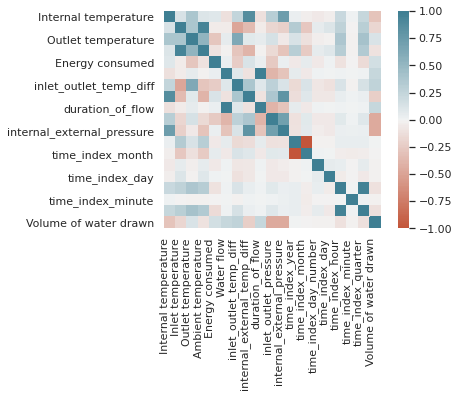

In [1693]:
# visualization of correlation matrix using a heatmap
event_train_corr_mat = event_train.corr()
ax = sns.heatmap(
    event_train_corr_mat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, 
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [1694]:
# correlation mat
event_train_corr_mat

,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow,inlet_outlet_temp_diff,internal_external_temp_diff,duration_of_flow,inlet_outlet_pressure,internal_external_pressure,time_index_year,time_index_month,time_index_day_number,time_index_day,time_index_hour,time_index_minute,time_index_quarter,Volume of water drawn
Internal temperature,1.000000,0.133637,0.381129,0.112390,0.088925,-0.116831,0.251138,0.868237,-0.116602,0.318387,0.727985,0.037535,-0.030742,-0.049264,-0.024071,0.220440,0.008884,0.228459,-0.289327
Inlet temperature,0.133637,1.000000,0.387854,0.945718,-0.041492,-0.044482,-0.474299,-0.348681,-0.044948,-0.173083,-0.214291,0.331861,-0.263851,0.058117,0.109477,0.278989,-0.000702,0.299845,-0.178232
Outlet temperature,0.381129,0.387854,1.000000,0.535001,-0.275057,0.060491,0.627491,0.085166,0.060868,0.148266,-0.060031,0.135538,-0.110499,-0.025283,-0.011762,0.373012,-0.009330,0.419479,0.119948
Ambient temperature,0.112390,0.945718,0.535001,1.000000,-0.092342,-0.016861,-0.287900,-0.395424,-0.017247,-0.155209,-0.289958,0.315113,-0.247154,0.047008,0.090922,0.320768,-0.010500,0.348942,-0.088593
Energy consumed,0.088925,-0.041492,-0.275057,-0.092342,1.000000,0.034754,-0.227665,0.128305,0.035098,-0.252192,0.036700,-0.061972,0.053175,-0.055685,0.011975,-0.096009,-0.005279,-0.145982,0.162569
Water flow,-0.116831,-0.044482,0.060491,-0.016861,0.034754,1.000000,0.095352,-0.099574,0.999919,-0.389943,-0.289666,0.055229,-0.052875,0.018710,0.005949,0.022652,0.003514,0.013046,0.233861
inlet_outlet_temp_diff,0.251138,-0.474299,0.627491,-0.287900,-0.227665,0.095352,1.000000,0.375893,0.096107,0.287826,0.123684,-0.150883,0.117347,-0.073243,-0.103715,0.120599,-0.008319,0.147363,0.265128
internal_external_temp_diff,0.868237,-0.348681,0.085166,-0.395424,0.128305,-0.099574,0.375893,1.000000,-0.099170,0.371801,0.817697,-0.122644,0.094991,-0.069009,-0.067648,0.043602,0.013455,0.036946,-0.223206
duration_of_flow,-0.116602,-0.044948,0.060868,-0.017247,0.035098,0.999919,0.096107,-0.099170,1.000000,-0.390830,-0.290242,0.054587,-0.052249,0.018392,0.006081,0.022667,0.003466,0.013186,0.234559
inlet_outlet_pressure,0.318387,-0.173083,0.148266,-0.155209,-0.252192,-0.389943,0.287826,0.371801,-0.390830,1.000000,0.714856,-0.104253,0.080717,-0.048259,-0.056859,0.078804,0.020017,0.099397,-0.449996


inlet_outlet_pressure and	internal_external_pressure are the features with the highest correlation with the target variable Volume of water drawn that is 0.449996 and	-0.447837 respectively. Also, Water flow,	inlet_outlet_temp_diff,	internal_external_temp_diff,	duration_of_flow and Internal temperature present correlations of the order 0.2xxx with the target variable.

In [1695]:
# description of train
print('event_train description')
event_train.describe()

event_train description


,Internal temperature,Inlet temperature,Outlet temperature,Ambient temperature,Energy consumed,Water flow,inlet_outlet_temp_diff,internal_external_temp_diff,duration_of_flow,inlet_outlet_pressure,internal_external_pressure,time_index_year,time_index_month,time_index_day_number,time_index_day,time_index_hour,time_index_minute,time_index_quarter,Volume of water drawn
count,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000,1844.000000
mean,48.902284,25.548046,52.929600,26.651304,45.884908,1.773861,27.381554,22.250980,531.284824,4.181658,3.602227,2020.246204,8.535249,3.798265,16.378525,13.734273,30.615510,1.851410,35.460954
std,10.282562,5.201814,5.881515,5.554371,94.986319,2.751086,6.157814,11.124039,822.958009,1.797842,2.421304,0.430916,4.363484,2.033223,8.548917,6.026789,17.380651,0.968098,50.530931
min,16.920000,12.230000,28.290000,12.650000,0.000000,1.000000,4.360000,-9.610000,299.248490,0.044592,-1.926827,2020.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,5.000000
25%,42.268750,21.691500,50.000000,22.407500,0.000000,1.000000,23.665625,15.681875,299.248490,2.636104,1.472035,2020.000000,10.000000,2.000000,10.000000,10.000000,14.500000,1.000000,5.000000
50%,51.837500,25.135000,54.460000,26.457500,0.000000,1.000000,28.270000,24.805000,299.248490,4.332854,3.560920,2020.000000,11.000000,4.000000,17.000000,14.000000,33.000000,2.000000,10.000000
75%,57.253750,28.677500,57.275833,30.860000,0.000000,2.000000,31.686250,30.281250,601.248490,5.728851,5.778475,2020.000000,11.000000,6.000000,24.000000,19.000000,48.000000,3.000000,45.000000
max,62.680000,45.660000,62.950000,44.190000,296.570000,105.000000,40.197500,43.920000,31371.248490,7.921844,8.806059,2021.000000,12.000000,7.000000,31.000000,23.000000,58.000000,3.000000,380.000000


# Data visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


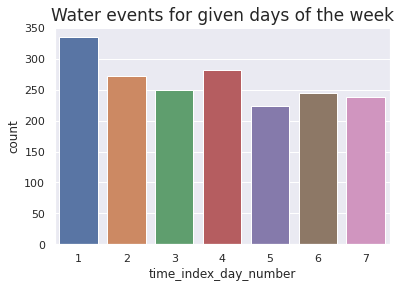

In [1696]:
sns.countplot(event_train['time_index_day_number'])
plt.title('Water events for given days of the week', fontdict={'size':17});

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


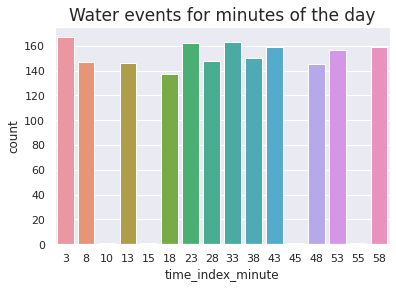

In [1697]:
sns.countplot(event_train['time_index_minute'])
plt.title('Water events for minutes of the day', fontdict={'size':17});

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


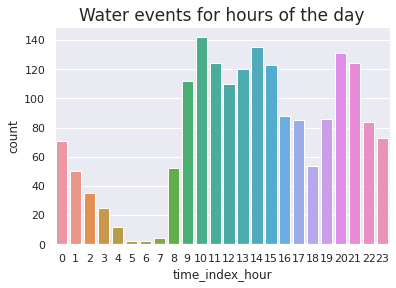

In [1698]:
sns.countplot(event_train['time_index_hour'])
plt.title('Water events for hours of the day', fontdict={'size':17});

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


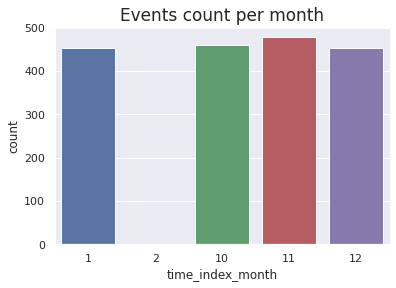

In [1699]:
sns.countplot(event_train['time_index_month'])
plt.title('Events count per month', fontdict={'size':17});

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


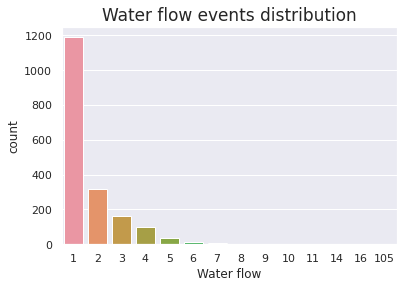

In [1700]:
sns.countplot(event_train['Water flow'])
plt.title('Water flow events distribution', fontdict={'size':17});

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


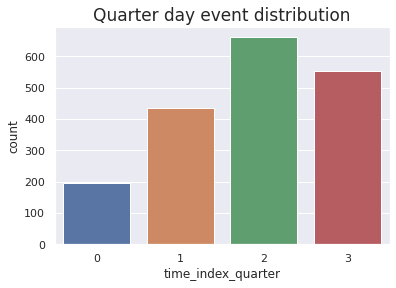

In [1701]:
sns.countplot(event_train['time_index_quarter'])
plt.title('Quarter day event distribution', fontdict={'size':17});

In [1702]:
# event with maximum water drawn
event_train.iloc[event_train['Volume of water drawn'].argmax(), :]

time_index                     07/10/20 09:38:25
Internal temperature                     26.1867
Inlet temperature                        18.7633
Outlet temperature                       40.1867
Ambient temperature                      18.4467
Energy consumed                          164.117
Water flow                                     3
inlet_outlet_temp_diff                   21.4233
internal_external_temp_diff                 7.74
duration_of_flow                         897.248
inlet_outlet_pressure                    1.43181
internal_external_pressure              0.517296
time_index_year                             2020
time_index_month                              10
time_index_day_number                          3
time_index_day                                 7
time_index_hour                                9
time_index_minute                             38
time_index_quarter                             1
Volume of water drawn                        380
Name: 55, dtype: obj

# Model and validation

In [1703]:
# Separate dependent variables from independent variables
cols = list(event_train.columns)
X = event_train[cols[1:-1]]
y = event_train[cols[-1]]

print(X.shape)
print(y.shape)

# Split data into train and test sets
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.25, random_state=42)

(1844, 18)
(1844,)


In [1704]:
def default_round_n(num, multiplier):
  return num + (multiplier - (num%multiplier))

In [1705]:
#Create array of models to evaluate
models = []
models.append(('LiR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('Bag_Re', BaggingRegressor()))
models.append(('RandomForest', RandomForestRegressor(n_estimators=20)))
models.append(('ExtraTreesRegressor', ExtraTreesRegressor(n_estimators=20)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))
models.append(('LGB', lgb.LGBMRegressor()))
models.append(('CBR', CatBoostRegressor(logging_level='Silent')))

# Evaluations
results = []
names = []
scoring = []

for name, model in models:
    # Fit the model
    model.fit(X_train, y_train)
    
    predictions = default_round_n(model.predict(X_valid), basic_unit_water_drawn_volume)
    
    # Evaluate the model
    score = mean_absolute_error(y_valid, predictions)

    results.append(score)
    names.append(name)
    
    msg = "%s: %f " % (name, score)
    print(msg)


LiR: 24.540130 
Ridge: 24.485900 
Lasso: 25.073753 
ElasticNet: 25.735358 
Bag_Re: 19.785249 
RandomForest: 20.815618 
ExtraTreesRegressor: 19.258134 
KNN: 22.950108 
CART: 27.616052 
SVM: 27.490239 
LGB: 18.225597 
CBR: 18.030369 


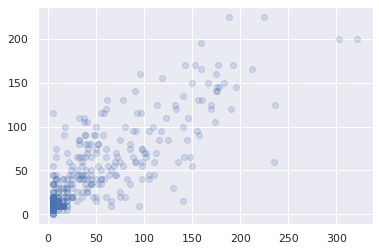

In [1706]:
plt.scatter(y_valid, predictions, alpha=0.2)

In [1707]:
# parameter tunning
model = CatBoostRegressor(logging_level = 'Silent')

grid = {'learning_rate': [0.01, 0.015, 0.02, 0.05, 0.1, 0.15],
        'depth': [4, 6], 
        'l2_leaf_reg': [1, 9, 11], 
        'iterations': [1500, 2000, 2500]}


reg_grid = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_absolute_error', cv=5, verbose = 3)
reg_grid.fit(X, y)
best_param = reg_grid.best_params_
best_score = reg_grid.best_score_
print(best_param)
print("best_score  = ", best_score)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01 .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, score=-20.157, total=   2.3s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01 .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, score=-18.186, total=   2.4s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01 .....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.7s remaining:    0.0s


[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, score=-17.740, total=   2.7s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01 .....
[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, score=-14.541, total=   2.5s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01 .....
[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.01, score=-18.941, total=   2.4s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.015 ....
[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.015, score=-20.247, total=   2.5s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.015 ....
[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.015, score=-18.225, total=   2.4s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.015 ....
[CV]  depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.015, score=-17.910, total=   2.4s
[CV] depth=4, iterations=1500, l2_leaf_reg=1, learning_rate=0.015 

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 43.0min finished


{'depth': 6, 'iterations': 2000, 'l2_leaf_reg': 9, 'learning_rate': 0.015}
best_score  =  -17.501419253329086


In [1708]:
model = CatBoostRegressor(depth=6, learning_rate=0.015, iterations=2000, logging_level='Silent')
model.fit(X_train, y_train)
score = mean_absolute_error(y_valid, model.predict(X_valid))
print(model, " mae_score = ", score, " model_score = ", model.score(X_valid, y_valid))


<catboost.core.CatBoostRegressor object at 0x7f83324ee2d0>  mae_score =  17.444582465098375  model_score =  0.6904467219054766


In [1709]:
# building final model with all the data
model = CatBoostRegressor(depth=6, learning_rate=0.015, iterations=2000, logging_level='Silent')
model.fit(X, y)

In [1710]:
# prediction  of mean volume of water drawn and adjusting with number of Water flow and rounding up to the nearest multiple of 5
cols = list(event_test.columns)
X_test = event_test[cols[1:]]

pred = model.predict(X_test)
event_test['Forecast water volume drawn (L)'] =  default_round_n(pred * event_test['Water flow'], basic_unit_water_drawn_volume).astype(int)
event_test['Event start time'] = event_test['time_index']

# correction of any prediction less than or equal to zero to the minimum base prediction which is 5 litres
event_test['Forecast water volume drawn (L)'] = event_test['Forecast water volume drawn (L)'].replace(0, basic_unit_water_drawn_volume)
ss = event_test[['Event start time', 'Forecast water volume drawn (L)']]


In [1711]:
# confirming we have no negative prediction
ss[ss['Forecast water volume drawn (L)'] <= 0].any()

Event start time                   False
Forecast water volume drawn (L)    False
dtype: bool

In [1712]:
# view first ten prediction
ss.head(10)

,Event start time,Forecast water volume drawn (L)
0,01/02/21 09:58:21,10
1,01/02/21 10:28:21,170
2,01/02/21 10:58:21,260
3,01/02/21 12:03:22,105
4,01/02/21 12:38:24,35
5,01/02/21 14:03:23,115
6,01/02/21 14:23:25,175
7,01/02/21 14:43:22,30
8,01/02/21 14:58:23,15
9,01/02/21 15:33:22,55


In [1714]:
# creating of prediction file
ss.to_csv('geyser_prediction.csv', index=False)